##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [28]:
#%pip install pandas 
#%pip install matplotlib
#%pip install pyarrow
#%pip install seaborn
#%pip install sklearn
#%pip install datetime

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [29]:
# Can have as many cells as you want for code
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV
from datetime import datetime
from sklearn.preprocessing import StandardScaler

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

### 1. Data Exploration

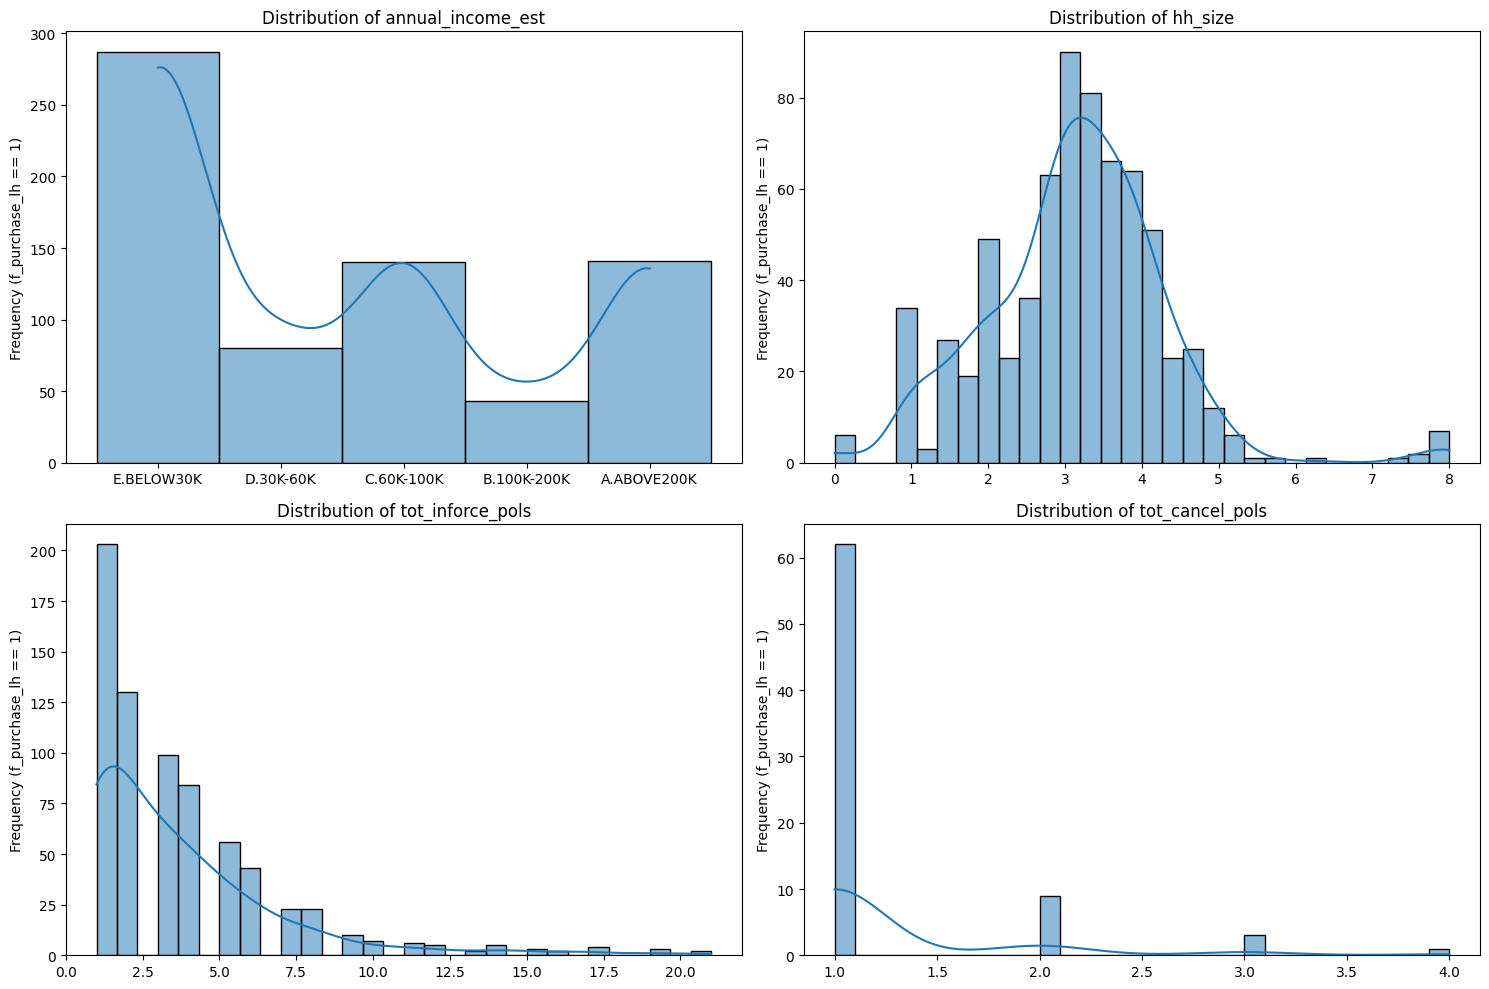

Number of duplicated 'clntnum' values: 0


In [30]:
filepath = "./data/catB_train.parquet" 
df = pd.read_parquet(filepath)
# print(df.dtypes)

def data_exploration_quadrants(dataframe, target_column, continuous_columns):
    """
    Plot distributions of continuous columns in 4 quadrants based on a filtered DataFrame.

    Parameters:
    - dataframe: DataFrame to filter and plot
    - target_column: Target column for filtering
    - continuous_columns: List of continuous columns to plot
    """
    # Filtering the DataFrame based on the target column
    filtered_df = dataframe[dataframe[target_column] == 1].copy()

    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Flatten the axes for easier indexing
    axes = axes.flatten()

    for i, col in enumerate(continuous_columns):
        # Determine the quadrant based on the index
        quadrant = i % 4

        # Sorting categories lexicographically for 'annual_income_est'
        if col == 'annual_income_est':
            sorted_categories = sorted(filtered_df[col].dropna().unique(), reverse=True)
            filtered_df[col] = pd.Categorical(filtered_df[col], categories=sorted_categories, ordered=True)

        # Plotting histograms for continuous columns in the corresponding quadrant
        sns.histplot(filtered_df[col], bins=30, kde=True, ax=axes[quadrant])
        axes[quadrant].set_title(f'Distribution of {col}')
        axes[quadrant].set_xlabel('')
        axes[quadrant].set_ylabel(f'Frequency ({target_column} == 1)')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

continuous_cols = ['annual_income_est', 'hh_size', 'tot_inforce_pols', 'tot_cancel_pols']
data_exploration_quadrants(df, 'f_purchase_lh', continuous_cols)

#flg_latest_being_lapse, flg_latest_being_cancel, tot_inforce_pols do not have missing values
empty_val_check = df[['flg_latest_being_lapse','flg_latest_being_cancel','tot_inforce_pols']]
empty_val_check.isna().sum().sum()

# Check for duplicated rows
duplicated_clntnum_count = df['clntnum'].duplicated(keep=False).sum()
print(f"Number of duplicated 'clntnum' values: {duplicated_clntnum_count}")

In [31]:
# Old Codes for reference
# # Filtering the DataFrame where 'f_purchase_lh' equals 1
# filtered_df = df[df['f_purchase_lh'] == 1].copy()

# # Plotting distributions of continuous columns based on the filtered DataFrame
# continuous_cols = ['annual_income_est', 'hh_size', 'tot_inforce_pols', 'tot_cancel_pols']
# fig, axes = plt.subplots(len(continuous_cols), 1, figsize=(10, 5 * len(continuous_cols)))

# for i, col in enumerate(continuous_cols):
#     if col == 'annual_income_est':
#         # Sorting categories lexicographically for 'annual_income_est'
#         sorted_categories = sorted(filtered_df[col].dropna().unique(), reverse=True)
#         filtered_df[col] = pd.Categorical(filtered_df[col], categories=sorted_categories, ordered=True)
#         sns.histplot(filtered_df[col], bins=len(sorted_categories), kde=True, ax=axes[i])
#     else:
#         # Plotting histograms for other continuous columns
#         sns.histplot(filtered_df[col], bins=30, kde=True, ax=axes[i])
    
#     axes[i].set_title(f'Distribution of {col}')
#     axes[i].set_xlabel('')
#     axes[i].set_ylabel('Frequency (f_purchase_lh == 1)')

# plt.tight_layout()
# plt.show()

### 2. Data Cleaning Functions

##### Clean Target Column

In [56]:
def clean_target_column(dataframe, target_column):
    """
    Convert the specified target column to binary (0 or 1), filling missing values with 0.

    Parameters:
    - dataframe: DataFrame to modify
    - target_column: Target column to convert
    """
    dataframe[target_column].fillna(0, inplace=True)
    dataframe[target_column] = dataframe[target_column].astype(int)

    return dataframe

##### Pre-Process Dates and Age

In [33]:
def preprocess_dates_and_age(dataframe):
    """
    Preprocess date columns and calculate length of interaction and age in years.

    Parameters:
    - dataframe: DataFrame to modify
    - min_occ_date_col: Column containing date of interaction
    - cltdob_fix_col: Column containing date of birth

    Returns:
    - Modified DataFrame
    """
    # Convert date columns to datetime
    dataframe['min_occ_date'] = pd.to_datetime(dataframe['min_occ_date'], errors='coerce')
    dataframe['cltdob_fix'] = pd.to_datetime(dataframe['cltdob_fix'], errors='coerce')

    # Calculate length of interaction in days
    dataframe['length_of_interaction'] = (datetime.now() - dataframe['min_occ_date']).dt.days
    dataframe['length_of_interaction'].fillna(dataframe['length_of_interaction'].median(), inplace=True)

    # Calculate age in years
    dataframe['age'] = (datetime.now() - dataframe['cltdob_fix']) / pd.Timedelta(days=365.25)
    dataframe['age'].fillna(dataframe['age'].median(), inplace=True)

    return dataframe

#### A. General Client Information

In [34]:
def impute_client_info(dataframe):
    """
    Impute missing values for client information.

    Parameters:
    - dataframe: DataFrame to impute

    Returns:
    - DataFrame with imputed values
    """
    clnt_info_columns = ['race_desc', 'ctrycode_desc', 'cltsex_fix', 'clntnum', 'clttype', 'stat_flag', 'min_occ_date', 'cltdob_fix']

    for clnt_info_column in clnt_info_columns:
        dataframe[clnt_info_column] = dataframe[clnt_info_column].fillna(dataframe[clnt_info_column].mode()[0])

    return dataframe

#### B. Client Risk and Status Indicators

In [35]:
def impute_client_risk_status(dataframe):
    """
    Impute missing values for client risk and status indicator columns.

    Parameters:
    - dataframe: DataFrame containing client risk and status indicator columns

    Returns:
    - DataFrame with missing values imputed for specified columns
    """
    # Define client risk and status indicator columns
    clnt_risk_status_columns = [
        'flg_substandard', 'flg_is_borderline_standard', 'flg_is_revised_term',
        'flg_is_rental_flat', 'flg_has_health_claim', 'flg_has_life_claim',
        'flg_gi_claim', 'flg_is_proposal', 'flg_with_preauthorisation', 'flg_is_returned_mail'
    ]

    # Impute missing values for each column with its mode
    for clnt_risk_status_column in clnt_risk_status_columns:
        dataframe[clnt_risk_status_column] = dataframe[clnt_risk_status_column].fillna(dataframe[clnt_risk_status_column].mode()[0])

    # Display the count of missing values after imputation
    print(dataframe[clnt_risk_status_columns].isna().sum())

    return dataframe


#### C. Client Consent and Communication Preferences

In [36]:
def impute_client_consent(dataframe):
    """
    Impute missing values for client consent and communication preferences columns.

    Parameters:
    - dataframe: DataFrame containing client consent columns

    Returns:
    - DataFrame with missing values imputed for specified columns
    """
    # Define client consent columns
    clnt_consent_columns = [
        'is_consent_to_mail', 'is_consent_to_email', 'is_consent_to_call',
        'is_consent_to_sms', 'is_valid_dm', 'is_valid_email'
    ]

    # Impute missing values for each column with its mode
    for clnt_consent_column in clnt_consent_columns:
        dataframe[clnt_consent_column] = dataframe[clnt_consent_column].fillna(dataframe[clnt_consent_column].mode()[0])

    return dataframe

#### D. Policy and Claim History

In [37]:
def impute_negative_and_recency(dataframe):
    """
    Impute negative values for 'n_months_last_bought_products' and recency-related columns.

    Parameters:
    - dataframe: DataFrame containing relevant columns

    Returns:
    - DataFrame with negative values and missing values imputed for specified columns
    """
    # Impute negative values for 'n_months_last_bought_products'
    median_without_negatives = dataframe['n_months_last_bought_products'][dataframe['n_months_last_bought_products'] >= 0].median()
    dataframe['n_months_last_bought_products'] = dataframe['n_months_last_bought_products'].apply(lambda x: x if x >= 0 else median_without_negatives)

    # Impute 'recency_lapse' with 9999 if 'flg_latest_being_lapse' == 0, otherwise with median
    dataframe.loc[dataframe['flg_latest_being_lapse'] == 0, 'recency_lapse'] = 9999
    dataframe.loc[(dataframe['flg_latest_being_lapse'] == 1) & (dataframe['recency_lapse'].isna()), 'recency_lapse'] = 0

    # Impute 'recency_cancel' with 9999 if 'flg_latest_being_cancel' == 0, otherwise with median
    dataframe.loc[dataframe['flg_latest_being_cancel'] == 0, 'recency_cancel'] = 9999
    dataframe.loc[(dataframe['flg_latest_being_cancel'] == 1) & (dataframe['recency_cancel'].isna()), 'recency_cancel'] = 0

    # Impute missing values of 'tot_cancel_pols'
    dataframe.loc[dataframe['flg_latest_being_cancel'] == 0, 'tot_cancel_pols'] = 0
    dataframe.loc[(dataframe['tot_cancel_pols'].isna()) & (dataframe['flg_latest_being_cancel'] == 1), 'tot_cancel_pols'] = 1

    # Impute missing values of 'f_ever_declined_la'
    dataframe['f_ever_declined_la'].fillna(0, inplace=True)

    return dataframe

#### E. Demographic and Household Information, and Other Flags and Metrics

In [38]:
def impute_demographic_household(dataframe):
    """
    Converting data types, applying mappings, and filling missing values for Demographic and Household Information

    Parameters:
    - dataframe: DataFrame to preprocess

    Returns:
    - Preprocessed DataFrame
    """
    # Convert the data type of 'hh_size_est' to the correct data type
    dataframe['hh_size_est'].replace('>4', 5, inplace=True)
    dataframe['hh_size_est'] = pd.to_numeric(dataframe['hh_size_est'], errors='coerce')

    # Mapping for 'annual_income_est' column
    income_mapping = {
        'A.ABOVE200K': 200001,  
        'B.100K-200K': 150000,  
        'C.60K-100K': 80000,
        'D.30K-60K': 45000,
        'E.BELOW30K': 15000
    }
    # Apply the mapping to the 'annual_income_est' column
    dataframe['annual_income_est'].replace(income_mapping, inplace=True)

    # Fill in missing values with the median for specified columns
    col_names_fill_median = ['hh_20', 'pop_20', 'hh_size', 'hh_size_est', 'annual_income_est']
    for c in col_names_fill_median:
        dataframe[c] = pd.to_numeric(dataframe[c], errors='coerce')
        median_value = dataframe[c].median()
        dataframe[c].fillna(median_value, inplace=True)

    # Fill in missing values with the mode for specified columns
    col_names_fill_mode = ['is_housewife_retiree', 'is_sg_pr', 'is_class_1_2', 'is_dependent_in_at_least_1_policy']
    for c in col_names_fill_mode:
        mode_value = dataframe[c].mode()[0]
        dataframe[c].fillna(mode_value, inplace=True)
        dataframe[c] = dataframe[c].astype(int)

    # Fill in missing values with 0 for specified columns
    col_names_fill_zero = ['flg_affconnect_show_interest_ever', 'flg_affconnect_ready_to_buy_ever', 'flg_affconnect_lapse_ever', 'affcon_visit_days', 'clmcon_visit_days']
    for c in col_names_fill_zero:
        dataframe[c].fillna(0, inplace=True)
        dataframe[c] = dataframe[c].astype(int)

    # Fill in missing values with 0 for numeric columns
    for c in dataframe.loc[:, 'hlthclaim_amt':'flg_gi_claim_856320_ever']:
        dataframe[c].fillna(0, inplace=True)
        dataframe[c] = dataframe[c].astype(float)

    # Fill in missing values with 9999 for specified columns
    col_names_fill_9999 = ['n_months_since_visit_affcon', 'recency_clmcon', 'recency_clmcon_regis']
    for c in col_names_fill_9999:
        dataframe[c].fillna(9999, inplace=True)
        dataframe[c] = dataframe[c].astype(int)

    return dataframe

#### F. Cleaning Purchase and Lapse Metrics for Specific Products

In [39]:
# # Checking number of empty values in lapse data
# lapse_specific = df.loc[:, 'lapse_ape_ltc_1280bf':'n_months_since_lapse_32c74c']
# lapse_specific.isna().sum().sum()

# # Fill in missing values with 0 for lapses
# for column in df.loc[:, 'lapse_ape_ltc_1280bf':'lapse_ape_32c74c']:
#     df[column] = df[column].fillna(0)

# # Fill in missing values with 9999 for n_months_since_lapse
# for column in df.loc[:, 'n_months_since_lapse_ltc_1280bf':'n_months_since_lapse_32c74c']:
#     df[column] = df[column].fillna(9999)

# df['n_months_since_lapse_ltc_1280bf'][13337] # checking

# # Checking number of empty values in purchase data
# purchase_specific = df.loc[:, 'f_ever_bought_839f8a':'n_months_last_bought_32c74c']
# purchase_specific.isna().sum().sum() # 0 -> no missing values

In [40]:
def fill_missing_lapse_purchase_data(dataframe):
    """
    Fill missing values in lapse and purchase data columns with specified values.

    Parameters:
    - dataframe: DataFrame to fill missing values

    Returns:
    - DataFrame with missing values filled
    """
    # Checking number of empty values in lapse data
    lapse_specific = dataframe.loc[:, 'lapse_ape_ltc_1280bf':'n_months_since_lapse_32c74c']
    lapse_empty_sum = lapse_specific.isna().sum().sum()

    # Fill in missing values with 0 for lapses
    for column in dataframe.loc[:, 'lapse_ape_ltc_1280bf':'lapse_ape_32c74c']:
        dataframe[column] = dataframe[column].fillna(0)

    # Fill in missing values with 9999 for n_months_since_lapse
    for column in dataframe.loc[:, 'n_months_since_lapse_ltc_1280bf':'n_months_since_lapse_32c74c']:
        dataframe[column] = dataframe[column].fillna(9999)

    # Checking number of empty values in purchase data
    purchase_specific = dataframe.loc[:, 'f_ever_bought_839f8a':'n_months_last_bought_32c74c']
    purchase_empty_sum = purchase_specific.isna().sum().sum()

    return dataframe

#### One-Hot Encoding

In [41]:
def one_hot_encode_categorical(dataframe):
    """
    One-hot encode categorical variables in a DataFrame.

    Parameters:
    - dataframe: DataFrame containing categorical variables

    Returns:
    - DataFrame with one-hot encoded categorical variables
    """
    # Identify categorical columns
    categorical_columns = dataframe.select_dtypes(include=['object']).columns

    # Display categorical columns
    print("Categorical Columns:")
    print(categorical_columns)

    # One-hot encode categorical variables
    dataframe_encoded = pd.get_dummies(dataframe, columns=categorical_columns)

    return dataframe_encoded

#### Feature Scaling

In [42]:
def standardise_numerical_features(dataframe):
    """
    Apply standard scaling to numerical features in a DataFrame.

    Parameters:
    - dataframe: DataFrame containing numerical features

    Returns:
    - DataFrame with standardized numerical features
    """
    scaler = StandardScaler()

    # Identify numerical features
    numerical_features = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Apply standard scaling to numerical features
    dataframe[numerical_features] = scaler.fit_transform(dataframe[numerical_features])

    return dataframe

##### Overall Data Cleaning Function

In [65]:
# Overall Data Cleaning Function
def clean_data(dataframe, target_column):
    # Pre-Processing
    result = dataframe
    result = preprocess_dates_and_age(result)
    result = fill_missing_lapse_purchase_data(result)


    # Imputing
    result = impute_client_info(result)
    result = impute_client_risk_status(result)
    result = impute_client_consent(result)
    result = impute_negative_and_recency(result)
    result = impute_demographic_household(result)

    result = clean_target_column(result, target_column)
    result = one_hot_encode_categorical(result)
    result = standardise_numerical_features(result)

    return dataframe

target_column = 'f_purchase_lh'
df = clean_data(df, target_column)
# df.head()
# df.isna().sum()

flg_substandard               0
flg_is_borderline_standard    0
flg_is_revised_term           0
flg_is_rental_flat            0
flg_has_health_claim          0
flg_has_life_claim            0
flg_gi_claim                  0
flg_is_proposal               0
flg_with_preauthorisation     0
flg_is_returned_mail          0
dtype: int64
Categorical Columns:
Index(['clntnum', 'race_desc', 'ctrycode_desc', 'clttype', 'stat_flag',
       'cltsex_fix', 'ape_gi_42e115', 'ape_ltc_1280bf', 'ape_grp_6fc3e6',
       'ape_grp_de05ae',
       ...
       'n_months_last_bought_grp_fd3bfb', 'n_months_last_bought_lh_e22a6a',
       'n_months_last_bought_grp_70e1dd', 'n_months_last_bought_grp_e04c3a',
       'n_months_last_bought_grp_fe5fb8', 'n_months_last_bought_grp_94baec',
       'n_months_last_bought_grp_e91421', 'n_months_last_bought_lh_f852af',
       'n_months_last_bought_lh_947b15', 'n_months_last_bought_32c74c'],
      dtype='object', length=198)


clntnum                     0
race_desc                   0
ctrycode_desc               0
clttype                     0
stat_flag                   0
                           ..
flg_gi_claim_42e115_ever    0
flg_gi_claim_856320_ever    0
f_purchase_lh               0
length_of_interaction       0
age                         0
Length: 306, dtype: int64

In [ ]:
# Old Codes (For reference)

# # Convert target col to 0 or 1 (binary)
# df["f_purchase_lh"].fillna(0, inplace=True)

# df['min_occ_date'] = pd.to_datetime(df['min_occ_date'], errors='coerce')
# df['cltdob_fix'] = pd.to_datetime(df['cltdob_fix'], errors='coerce')

# # Calculate the length of interaction in days
# df['length_of_interaction'] = (datetime.now() - df['min_occ_date']).dt.days
# df['length_of_interaction'].fillna(df['length_of_interaction'].median(), inplace=True)

# # Calculate the age in years
# df['age'] = (datetime.now() - df['cltdob_fix']) / pd.Timedelta(days=365.25)
# df['age'].fillna(df['age'].median(), inplace=True)

# scaler = StandardScaler()
# # Identify numerical features
# numerical_features = df_encoded.select_dtypes(include=['float64', 'int64']).columns
# # Apply standard scaling to numerical features
# df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])

# #imputing missing values for client information
# clnt_info_columns = ['race_desc', 'ctrycode_desc', 'cltsex_fix', 'clntnum', 'clttype', 'stat_flag', 'min_occ_date', 'cltdob_fix']
# for clnt_info_column in clnt_info_columns:
#     df[clnt_info_column] = df[clnt_info_column].fillna(df[clnt_info_column].mode()[0])
# df[['race_desc', 'ctrycode_desc', 'cltsex_fix', 'stat_flag', 'clttype']].isna().sum()
# #imputing missing client risk and status indicator
# clnt_risk_status_columns = ['flg_substandard', 'flg_is_borderline_standard', 'flg_is_revised_term', 'flg_is_rental_flat', 'flg_has_health_claim', 'flg_has_life_claim', 'flg_gi_claim', 'flg_is_proposal', 'flg_with_preauthorisation', 'flg_is_returned_mail']
# for clnt_risk_status_column in clnt_risk_status_columns:
#     df[clnt_risk_status_column] = df[clnt_risk_status_column].fillna(df[clnt_risk_status_column].mode()[0])
# df[['flg_substandard', 'flg_is_borderline_standard', 'flg_is_revised_term', 'flg_is_rental_flat', 'flg_has_health_claim', 'flg_has_life_claim', 'flg_gi_claim', 'flg_is_proposal', 'flg_with_preauthorisation', 'flg_is_returned_mail']].isna().sum()
# #imputing missing client consent and communication preferences
# clnt_consent_columns = ['is_consent_to_mail', 'is_consent_to_email', 'is_consent_to_call', 'is_consent_to_sms', 'is_valid_dm', 'is_valid_email']
# for clnt_consent_column in clnt_consent_columns:
#     df[clnt_consent_column] = df[clnt_consent_column].fillna(df[clnt_consent_column].mode()[0])
# df[['is_consent_to_mail', 'is_consent_to_email', 'is_consent_to_call', 'is_consent_to_sms', 'is_valid_dm', 'is_valid_email']].isna().sum()

# #imputing negative values for n_months_last_bought_products, no missing values
# median_without_negatives = df['n_months_last_bought_products'][df['n_months_last_bought_products'] >= 0].median()
# df['n_months_last_bought_products'] = df['n_months_last_bought_products'].apply(lambda x: x if x >= 0 else median_without_negatives)
# #imputing recency_lapse with 9999 if flg_latest_being_lapse == 0, otherwise median 
# df.loc[df['flg_latest_being_lapse'] == 0, 'recency_lapse'] = 9999
# df.loc[(df['flg_latest_being_lapse'] == 1) & (df['recency_lapse'].isna()), 'recency_lapse'] = 0
# df['flg_latest_being_lapse'].isna().sum()
# #doing the same for cancellations
# df.loc[df['flg_latest_being_cancel'] == 0, 'recency_cancel'] = 9999
# df.loc[(df['flg_latest_being_cancel'] == 1) & (df['recency_cancel'].isna()), 'recency_cancel'] = 0
# df['flg_latest_being_cancel'].isna().sum()
# #tot_inforce_pols has no missing values
# #imputing missing values of tot_cancel_pols
# df.loc[df['flg_latest_being_cancel'] == 0, 'tot_cancel_pols'] = 0
# df.loc[(df['tot_cancel_pols'].isna()) & (df['flg_latest_being_cancel'] == 1), 'tot_cancel_pols'] = 1
# #imputing missing values of f_ever_declined_la
# df['f_ever_declined_la'].fillna(0, inplace=True)

# # Convert the data type of the column to the correct data type
# df['hh_size_est'].replace('>4', 5, inplace=True)
# df['hh_size_est'] = pd.to_numeric(df['hh_size_est'], errors='coerce')
# income_mapping = {
#     'A.ABOVE200K': 200001,  
#     'B.100K-200K': 150000,  
#     'C.60K-100K': 80000,
#     'D.30K-60K': 45000,
#     'E.BELOW30K': 15000
# }
# # Apply the mapping to the 'annual_income' column
# df['annual_income_est'].replace(income_mapping, inplace=True)
# # Fill in missing values with the median 
# col_names_fill_median = ['hh_20', 'pop_20', 'hh_size', 'hh_size_est', 'annual_income_est']
# for c in col_names_fill_median:
#     df[c] = pd.to_numeric(df[c], errors='coerce')
#     median_value = df[c].median()
#     df[c].fillna(median_value, inplace=True)
# # Fill in missing values with the mode 
# col_names_fill_mode = ['is_housewife_retiree', 'is_sg_pr', 'is_class_1_2', 'is_dependent_in_at_least_1_policy']
# for c in col_names_fill_mode:
#     mode_value = df[c].mode()[0]
#     df[c].fillna(mode_value, inplace=True)
#     df[c] = df[c].astype(int)
# # Fill in missing values with 0
# col_names_fill_zero = ['flg_affconnect_show_interest_ever', 'flg_affconnect_ready_to_buy_ever', 'flg_affconnect_lapse_ever', 'affcon_visit_days', 'clmcon_visit_days']
# for c in col_names_fill_zero:
#     df[c].fillna(0, inplace=True)
#     df[c] = df[c].astype(int)
# for c in df.loc[:, 'hlthclaim_amt':'flg_gi_claim_856320_ever']:
#     df[c].fillna(0, inplace=True)
#     df[c] = df[c].astype(float)
# # Fill in missing values with 9999
# col_names_fill_9999 = ['n_months_since_visit_affcon', 'recency_clmcon', 'recency_clmcon_regis']
# for c in col_names_fill_9999:
#     df[c].fillna(9999, inplace=True)
#     df[c] = df[c].astype(int)


# # One-hot encoding categorical variables
# categorical_columns = df.select_dtypes(include=['object']).columns
# print("Categorical Columns:")
# print(categorical_columns)
# df_encoded = pd.get_dummies(df, columns=categorical_columns)
# df.head()

### 4. Feature Selection

#### A. Filter Method

#### Using Pearson Correlation

In [ ]:
y = df['f_purchase_lh']

In [ ]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
non_numeric_cols = df.select_dtypes(include=["string", "object", "datetime64[ns]"]).columns

df = df.drop(columns=non_numeric_cols)

KeyError: "['clntnum', 'race_desc', 'ctrycode_desc', 'clttype', 'stat_flag', 'min_occ_date', 'cltdob_fix', 'cltsex_fix', 'ape_gi_42e115', 'ape_ltc_1280bf', 'ape_grp_6fc3e6', 'ape_grp_de05ae', 'ape_inv_dcd836', 'ape_grp_945b5a', 'ape_grp_6a5788', 'ape_ltc_43b9d5', 'ape_grp_9cdedf', 'ape_lh_d0adeb', 'ape_grp_1581d7', 'ape_grp_22decf', 'ape_lh_507c37', 'ape_lh_839f8a', 'ape_inv_e9f316', 'ape_gi_a10d1b', 'ape_gi_29d435', 'ape_grp_caa6ff', 'ape_grp_fd3bfb', 'ape_lh_e22a6a', 'ape_grp_70e1dd', 'ape_grp_e04c3a', 'ape_grp_fe5fb8', 'ape_gi_856320', 'ape_grp_94baec', 'ape_gi_058815', 'ape_grp_e91421', 'ape_lh_f852af', 'ape_lh_947b15', 'ape_32c74c', 'sumins_gi_42e115', 'sumins_ltc_1280bf', 'sumins_grp_6fc3e6', 'sumins_grp_de05ae', 'sumins_inv_dcd836', 'sumins_grp_945b5a', 'sumins_grp_6a5788', 'sumins_ltc_43b9d5', 'sumins_grp_9cdedf', 'sumins_lh_d0adeb', 'sumins_grp_1581d7', 'sumins_grp_22decf', 'sumins_lh_507c37', 'sumins_inv_e9f316', 'sumins_gi_a10d1b', 'sumins_gi_29d435', 'sumins_grp_caa6ff', 'sumins_grp_fd3bfb', 'sumins_lh_e22a6a', 'sumins_grp_70e1dd', 'sumins_grp_e04c3a', 'sumins_grp_fe5fb8', 'sumins_gi_856320', 'sumins_grp_94baec', 'sumins_gi_058815', 'sumins_grp_e91421', 'sumins_lh_f852af', 'sumins_lh_947b15', 'sumins_32c74c', 'prempaid_gi_42e115', 'prempaid_ltc_1280bf', 'prempaid_grp_6fc3e6', 'prempaid_grp_de05ae', 'prempaid_inv_dcd836', 'prempaid_grp_945b5a', 'prempaid_grp_6a5788', 'prempaid_ltc_43b9d5', 'prempaid_grp_9cdedf', 'prempaid_lh_d0adeb', 'prempaid_grp_1581d7', 'prempaid_grp_22decf', 'prempaid_lh_507c37', 'prempaid_lh_839f8a', 'prempaid_inv_e9f316', 'prempaid_gi_a10d1b', 'prempaid_gi_29d435', 'prempaid_grp_caa6ff', 'prempaid_grp_fd3bfb', 'prempaid_lh_e22a6a', 'prempaid_grp_70e1dd', 'prempaid_grp_e04c3a', 'prempaid_grp_fe5fb8', 'prempaid_gi_856320', 'prempaid_grp_94baec', 'prempaid_gi_058815', 'prempaid_grp_e91421', 'prempaid_lh_f852af', 'prempaid_lh_947b15', 'prempaid_32c74c', 'ape_839f8a', 'ape_e22a6a', 'ape_d0adeb', 'ape_c4bda5', 'ape_ltc', 'ape_507c37', 'ape_gi', 'sumins_839f8a', 'sumins_e22a6a', 'sumins_d0adeb', 'sumins_c4bda5', 'sumins_ltc', 'sumins_507c37', 'sumins_gi', 'prempaid_839f8a', 'prempaid_e22a6a', 'prempaid_d0adeb', 'prempaid_c4bda5', 'prempaid_ltc', 'prempaid_507c37', 'prempaid_gi', 'lapse_ape_ltc_1280bf', 'lapse_ape_grp_6fc3e6', 'lapse_ape_grp_de05ae', 'lapse_ape_inv_dcd836', 'lapse_ape_grp_945b5a', 'lapse_ape_grp_6a5788', 'lapse_ape_ltc_43b9d5', 'lapse_ape_grp_9cdedf', 'lapse_ape_lh_d0adeb', 'lapse_ape_grp_1581d7', 'lapse_ape_grp_22decf', 'lapse_ape_lh_507c37', 'lapse_ape_lh_839f8a', 'lapse_ape_inv_e9f316', 'lapse_ape_grp_caa6ff', 'lapse_ape_grp_fd3bfb', 'lapse_ape_lh_e22a6a', 'lapse_ape_grp_70e1dd', 'lapse_ape_grp_e04c3a', 'lapse_ape_grp_fe5fb8', 'lapse_ape_grp_94baec', 'lapse_ape_grp_e91421', 'lapse_ape_lh_f852af', 'lapse_ape_lh_947b15', 'lapse_ape_32c74c', 'n_months_since_lapse_ltc_1280bf', 'n_months_since_lapse_grp_6fc3e6', 'n_months_since_lapse_grp_de05ae', 'n_months_since_lapse_inv_dcd836', 'n_months_since_lapse_grp_945b5a', 'n_months_since_lapse_grp_6a5788', 'n_months_since_lapse_ltc_43b9d5', 'n_months_since_lapse_grp_9cdedf', 'n_months_since_lapse_lh_d0adeb', 'n_months_since_lapse_grp_1581d7', 'n_months_since_lapse_grp_22decf', 'n_months_since_lapse_lh_507c37', 'n_months_since_lapse_lh_839f8a', 'n_months_since_lapse_inv_e9f316', 'n_months_since_lapse_grp_caa6ff', 'n_months_since_lapse_grp_fd3bfb', 'n_months_since_lapse_lh_e22a6a', 'n_months_since_lapse_grp_70e1dd', 'n_months_since_lapse_grp_e04c3a', 'n_months_since_lapse_grp_fe5fb8', 'n_months_since_lapse_grp_94baec', 'n_months_since_lapse_grp_e91421', 'n_months_since_lapse_lh_f852af', 'n_months_since_lapse_lh_947b15', 'n_months_since_lapse_32c74c', 'n_months_last_bought_839f8a', 'n_months_last_bought_e22a6a', 'n_months_last_bought_d0adeb', 'n_months_last_bought_c4bda5', 'n_months_last_bought_ltc', 'n_months_last_bought_507c37', 'n_months_last_bought_gi', 'n_months_last_bought_ltc_1280bf', 'n_months_last_bought_grp_6fc3e6', 'n_months_last_bought_grp_de05ae', 'n_months_last_bought_inv_dcd836', 'n_months_last_bought_grp_945b5a', 'n_months_last_bought_grp_6a5788', 'n_months_last_bought_ltc_43b9d5', 'n_months_last_bought_grp_9cdedf', 'n_months_last_bought_lh_d0adeb', 'n_months_last_bought_grp_1581d7', 'n_months_last_bought_grp_22decf', 'n_months_last_bought_lh_507c37', 'n_months_last_bought_lh_839f8a', 'n_months_last_bought_inv_e9f316', 'n_months_last_bought_grp_caa6ff', 'n_months_last_bought_grp_fd3bfb', 'n_months_last_bought_lh_e22a6a', 'n_months_last_bought_grp_70e1dd', 'n_months_last_bought_grp_e04c3a', 'n_months_last_bought_grp_fe5fb8', 'n_months_last_bought_grp_94baec', 'n_months_last_bought_grp_e91421', 'n_months_last_bought_lh_f852af', 'n_months_last_bought_lh_947b15', 'n_months_last_bought_32c74c', 'hlthclaim_amt', 'giclaim_amt'] not found in axis"

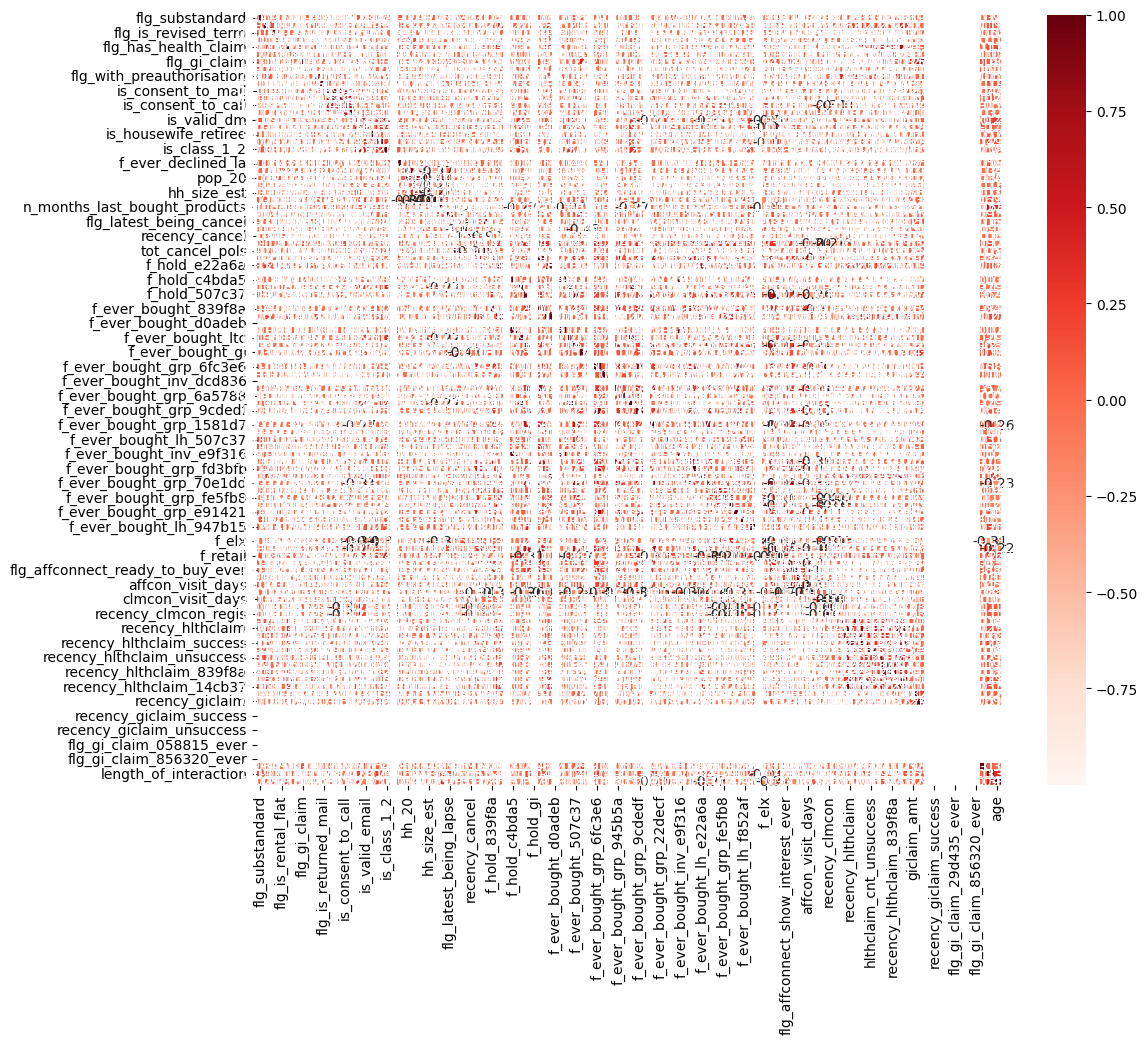

flg_gi_claim        0.141924
is_valid_dm         0.100784
is_valid_email      0.103897
f_ever_bought_gi    0.194966
f_purchase_lh       1.000000
Name: f_purchase_lh, dtype: float64

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#Correlation with output variable
cor_target = abs(cor['f_purchase_lh'])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features

In [ ]:
# Point-Biserial Correlation
from scipy.stats import pointbiserialr

# Define Features (X) and Target Variable (y)
X = df.drop('f_purchase_lh', axis=1)  # Features
y = df['f_purchase_lh']  # Target variable

# Exclude specific columns
columns_to_exclude = [
    'recency_giclaim', 'giclaim_cnt_success', 'recency_giclaim_success',
    'giclaim_cnt_unsuccess', 'recency_giclaim_unsuccess',
    'flg_gi_claim_29d435_ever', 'flg_gi_claim_058815_ever',
    'flg_gi_claim_42e115_ever', 'flg_gi_claim_856320_ever',
    'recency_hlthclaim', 'hlthclaim_cnt_success', 'recency_hlthclaim_success',
    'hlthclaim_cnt_unsuccess', 'recency_hlthclaim_unsuccess',
    'flg_hlthclaim_839f8a_ever', 'recency_hlthclaim_839f8a',
    'flg_hlthclaim_14cb37_ever', 'recency_hlthclaim_14cb37',
    'hlthclaim_amt', 'giclaim_amt'
]

X = X.drop(columns=columns_to_exclude, errors='ignore')

# Ensure all arrays have the same length
correlation_coefficients, p_values, feature_names = [], [], []

for column in X.columns:
    if X[column].dtype != 'object':  # Exclude non-numerical columns
        correlation_coefficient, p_value = pointbiserialr(X[column], y)
        correlation_coefficients.append(abs(correlation_coefficient))
        p_values.append(p_value)
        feature_names.append(column)

# Combine results into a DataFrame for easier analysis
correlation_df = pd.DataFrame({
    'Feature': feature_names,
    'Correlation Coefficient': correlation_coefficients,
    'P-Value': p_values
})

# Sort by absolute correlation coefficient in descending order
correlation_df = correlation_df.sort_values(by='Correlation Coefficient', ascending=False)

# Display the correlation results
print("Point-Biserial Correlation Results:")
print(correlation_df.head())

Point-Biserial Correlation Results:
             Feature  Correlation Coefficient        P-Value
46  f_ever_bought_gi                 0.194966  1.246762e-153
6       flg_gi_claim                 0.141924   1.354078e-81
15    is_valid_email                 0.103897   2.279149e-44
14       is_valid_dm                 0.100784   7.685873e-42
29     recency_lapse                 0.095848   5.450538e-38


c:\Users\ningy\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


#### Using SelectKBest (Mutual Information & Chi-Square)

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import train_test_split

X = df.drop('f_purchase_lh', axis=1)
y = df['f_purchase_lh']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=['string', 'object']).columns.tolist()

numeric_selector = SelectKBest(score_func=mutual_info_classif, k=5)
categorical_selector = SelectKBest(score_func=chi2, k=5)

X_train_numeric_selected = numeric_selector.fit_transform(X_train[numeric_cols], y_train)
X_train_categorical_selected = categorical_selector.fit_transform(X_train[categorical_cols], y_train)

selected_numeric_indices = numeric_selector.get_support(indices=True)
selected_categorical_indices = categorical_selector.get_support(indices=True)

selected_numeric_features = [numeric_cols[i] for i in selected_numeric_indices]
selected_categorical_features = [categorical_cols[i] for i in selected_categorical_indices]

X_train_selected = pd.concat([pd.DataFrame(X_train_numeric_selected), pd.DataFrame(X_train_categorical_selected)], axis=1)

selected_feature_names = selected_numeric_features + selected_categorical_features
X_train_selected.columns = selected_feature_names

print("Selected Numeric Features:")
print(selected_numeric_features)
print("\nSelected Categorical Features:")
print(selected_categorical_features)
print("\nSelected Data:")
print(X_train_selected.head())


Selected Numeric Features:
['is_valid_dm', 'is_valid_email', 'n_months_last_bought_products', 'recency_lapse', 'f_ever_bought_gi']

Selected Categorical Features:
['annual_income_est', 'recency_lapse', 'n_months_since_visit_affcon', 'hlthclaim_amt', 'giclaim_amt']

Selected Data:
   is_valid_dm  is_valid_email  n_months_last_bought_products  recency_lapse  \
0          1.0             1.0                            1.0         9999.0   
1          1.0             1.0                           33.0         9999.0   
2          1.0             1.0                           37.0         9999.0   
3          0.0             1.0                           83.0           83.0   
4          1.0             1.0                           14.0         9999.0   

   f_ever_bought_gi  annual_income_est  recency_lapse  \
0               0.0           200001.0         9999.0   
1               0.0            15000.0         9999.0   
2               0.0           200001.0         9999.0   
3         

#### B. Embedded Method

In [ ]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.838404
Best score using built-in LassoCV: 0.021248


In [ ]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 9 variables and eliminated the other 96 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

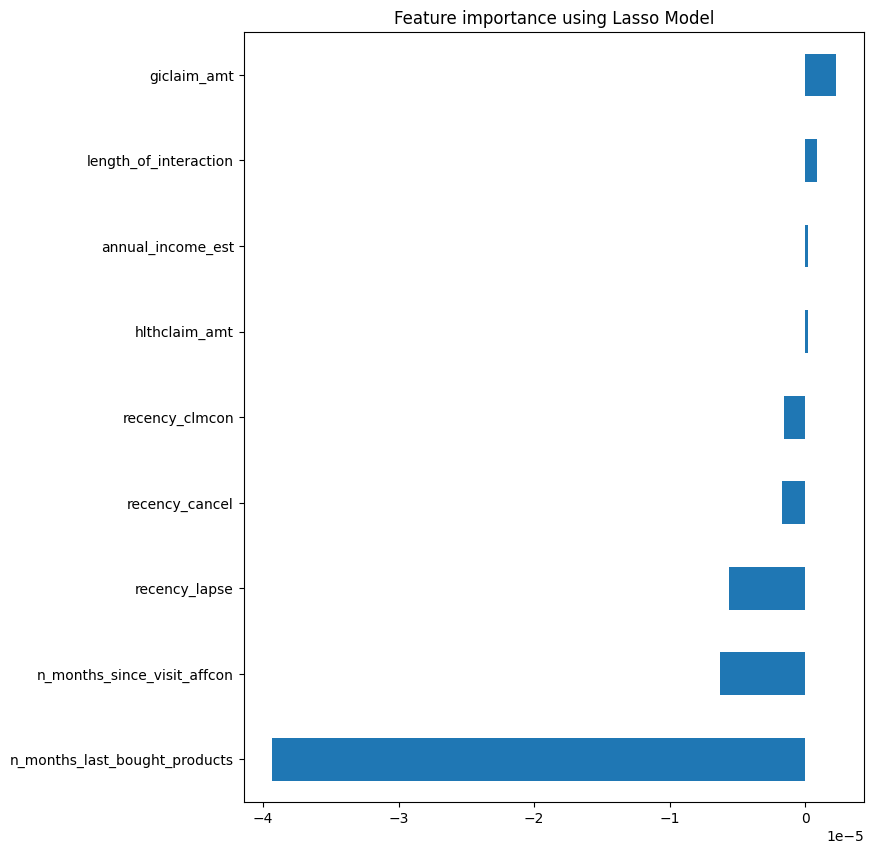

In [ ]:
imp_coef = coef.sort_values()
imp_coef = imp_coef[imp_coef != 0]
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [ ]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    result = [] 
    return result

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

[]


### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!